<a href="https://colab.research.google.com/github/Tandon-A/MLEND_Udacity/blob/master/Capstone_Project/FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Facial Emotion Recognition </center></h1>
<center>Final CNN model as trained on <a href="https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data">FER 2013 dataset</a></center>
<center> Project completed as part of Udacity Machine Learning engineer nanodegree </center>

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#/content/drive/My Drive//Colab//

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, classification_report


import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader 
import torchvision.models as models
from torchsummary import summary
from torchvision import transforms

# I. Data Loading

In [4]:
# Change this variable to specify the path 
FER_DATA_PATH = "/content/drive/My Drive/Colab/MLEND/icml_face_data.csv" 

fer_data = pd.read_csv(FER_DATA_PATH)
print (fer_data.shape)
fer_data.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


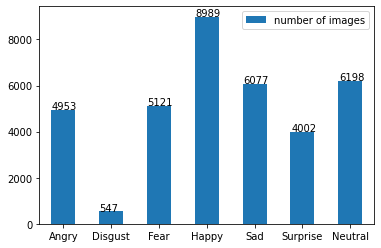

In [5]:
class_labels = fer_data.groupby('emotion').size()
indx2emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

df = pd.DataFrame({'number of images': class_labels.values}, index=list(indx2emotion.values()))
ax = df.plot.bar(rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Data extraction

In [6]:
fer_data[' pixels'] = fer_data[' pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

train = fer_data[fer_data[' Usage'] == 'Training']
val = fer_data[fer_data[' Usage'] == 'PublicTest']
test = fer_data[fer_data[' Usage'] == 'PrivateTest']

train_x = train.iloc[:, 2].values
train_x = np.vstack(train_x).reshape((-1, 48, 48, 1)).astype('float32')
train_x = train_x/255
train_y = train.iloc[:, 0].values
train_y = np.vstack(train_y).reshape(-1).astype('long')

val_x = val.iloc[:, 2].values
val_x = np.vstack(val_x).reshape((-1, 48, 48, 1)).astype('float32')
val_x = val_x/255
val_y = val.iloc[:, 0].values
val_y = np.vstack(val_y).reshape(-1).astype('long')

test_x = test.iloc[:, 2].values
test_x = np.vstack(test_x).reshape((-1, 48, 48, 1)).astype('float32')
test_x = test_x/255
test_y = test.iloc[:, 0].values
test_y = np.vstack(test_y).reshape(-1).astype('long')

print ('train_x', train_x.shape, 'train_y', train_y.shape)
print ('val_x', val_x.shape, 'val_y', val_y.shape)
print ('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (28709, 48, 48, 1) train_y (28709,)
val_x (3589, 48, 48, 1) val_y (3589,)
test_x (3589, 48, 48, 1) test_y (3589,)


# II. Data Visualization

## Average Face

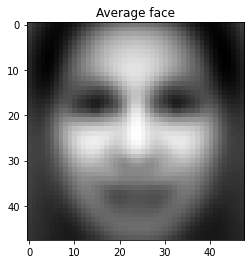

In [7]:
plt.figure(figsize=(6,4))
plt.imshow(np.mean(train_x, axis=0).reshape(48,48), cmap='gray')
plt.title("Average face")
plt.show()

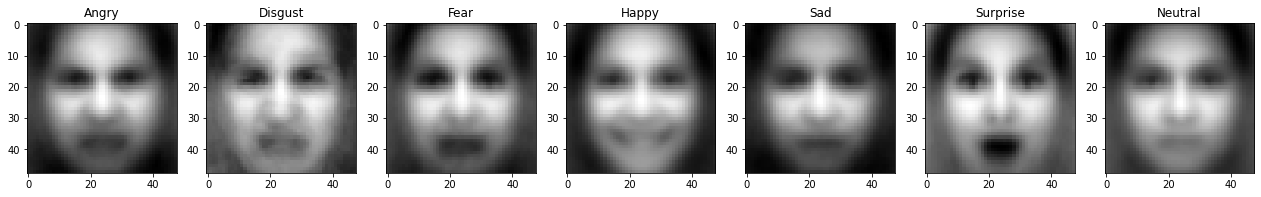

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(22, 8))
for i, ax in enumerate(axes):
  ax.imshow(np.mean(train_x[np.where(train_y == i)[0]], axis=0).reshape(48,48), cmap='gray')
  ax.set_title(indx2emotion[i])


## Sample Visualization

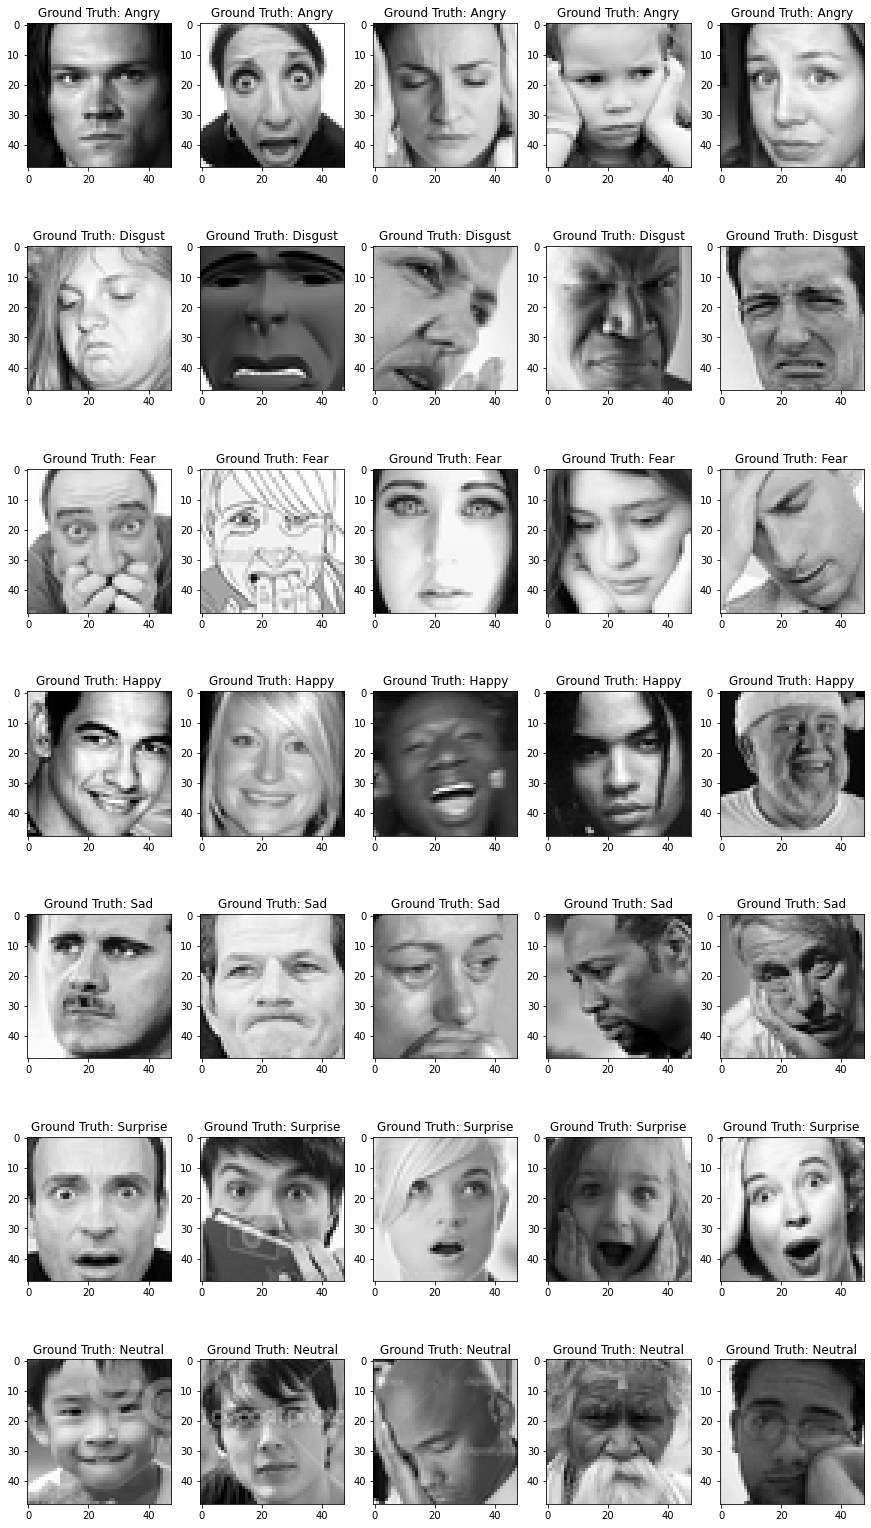

In [9]:
import random
plt.figure(figsize=[15,28])

plots = 1
for class_indx in range(7):
  class_imgs = random.sample(list(np.where(train_y == class_indx)[0]), 5)
  for image_idx in class_imgs:
    image = train_x[image_idx]
    plt.subplot(7, 5, plots)
    plt.imshow(image.reshape(48,48), cmap='gray')
    plt.title("Ground Truth: " + indx2emotion[class_indx])
    plots += 1


# plt.savefig('/content/drive/My Drive/Colab/MLEND/EDA.png')


# III. Data Loader Setup

In [10]:
class FERDataset(Dataset):
  def __init__(self, data_x, data_y, transform):
    super(FERDataset,self).__init__()
    self.data_x = data_x
    self.data_y = data_y
    self.transform = transform

  def __len__(self):
    return len(self.data_y)
  
  def __getitem__(self, index):
    x = self.data_x[index]
    y = self.data_y[index]
    return self.transform(x), y

print ('completed cell')

completed cell


In [11]:
batch_size = 128

mean = [0.5077]
std = [0.255]

train_transform = transforms.Compose([transforms.ToPILImage(), transforms.RandomOrder([transforms.RandomHorizontalFlip(), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), \
                                      transforms.RandomChoice([transforms.RandomRotation(degrees=10), transforms.RandomAffine(degrees=0, scale=(0.8, 0.9))])]),\
                                      transforms.ToTensor(), transforms.Normalize(mean, std=std), transforms.RandomErasing()])
test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(), transforms.Normalize(mean, std=std)])

train_dataset = FERDataset(train_x, train_y, train_transform)
val_dataset = FERDataset(val_x, val_y, test_transform)
test_dataset = FERDataset(test_x, test_y, test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  225 val loader  29 test 29
completed cell


# IV. Models

In [12]:
class FER_basic_model3_new(nn.Module):
  def __init__(self):
    super(FER_basic_model3_new, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.d1 = nn.Dropout(p=0.5)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.d2 = nn.Dropout(p=0.5)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.d3 = nn.Dropout(p=0.5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(in_features=256, out_features=512)
    self.d4 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.d5 = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(in_features=256, out_features=7)

  def forward(self, x):
    out = self.relu(self.conv1(x))
    out = self.relu(self.conv2(out))
    out = self.d1(self.pool(out))
    out = self.relu(self.conv3(out))
    out = self.relu(self.conv4(out))
    out = self.d2(self.pool(out))
    out = self.relu(self.conv5(out))
    out = self.relu(self.conv6(out))
    out = self.d3(self.pool(out))
    out = self.avgpool(out).reshape(-1, 256)
    out = self.d4(self.relu(self.fc1(out)))
    out = self.d5(self.relu(self.fc2(out)))
    out = self.fc3(out)
    return out

model = FER_basic_model3_new()
print (summary(model, (1, 48, 48), device='cpu'))
print ('completed cell')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          36,928
              ReLU-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
           Dropout-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]         147,584
             ReLU-10          [-1, 128, 24, 24]               0
        MaxPool2d-11          [-1, 128, 12, 12]               0
          Dropout-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         295,168
             ReLU-14          [-1, 256,

# V. Training

## Optimizer setup

In [13]:
for param in model.parameters():
  param.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingWarmRestarts(opt, 2, T_mult=10)

criterion = nn.NLLLoss()
activation = nn.LogSoftmax(dim=1)
print ('completed cell')

completed cell


## Training Method

In [14]:
def train_fer(epochs, model_path, opt, scheduler, criterion, activation, model):
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  train_loss = list()
  val_loss = list()
  train_acc = list()
  val_acc = list()

  best_epoch_acc = 0 
  best_acc = -1

  print ('starting training')
  for e in range(epochs):
    running_loss = 0.0 
    correct_pred = 0
    total_pred = 0 

    model.to(device)
    model.train
    
    for images_face, labels_face in iter(train_loader):
      images_face = images_face.to(device)
      labels_face = labels_face.to(device)

      opt.zero_grad()
      log_preds_face = activation(model(images_face))
      loss_batch = criterion(log_preds_face, labels_face)
      running_loss += loss_batch.item()
      topp, topk = torch.exp(log_preds_face).topk(1, dim=1)
      equals = topk == labels_face.view(*topk.shape)
      correct_pred += (equals == True).sum()
      total_pred += equals.shape[0]
      loss_batch.backward()
      opt.step()

    correct_pred = correct_pred.item()
    accuracy = correct_pred/total_pred
    if e % 20 == 0: 
      print ('epoch = %r training loss = %.4f accuracy = %.4f' %(e, running_loss, accuracy))
    train_loss.append(running_loss)
    train_acc.append(accuracy)

    
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0  

    model.eval()
    
    with torch.no_grad():
      for images_face, labels_face in iter(val_loader):
        images_face = images_face.to(device)
        labels_face = labels_face.to(device)
        log_preds_face = activation(model(images_face))
        loss_batch = criterion(log_preds_face, labels_face)
        running_loss += loss_batch.item()
        topp, topk = torch.exp(log_preds_face).topk(1, dim=1)
        equals = topk == labels_face.view(*topk.shape)
        correct_pred += (equals == True).sum()
        total_pred += equals.shape[0]
    
    correct_pred = correct_pred.item()
    accuracy = correct_pred/total_pred
    if e % 20 == 0:
      print ('epoch = %r validation loss = %.4f accuracy = %.4f' %(e, running_loss, accuracy))
    val_loss.append(running_loss)
    val_acc.append(accuracy)

    if accuracy > best_acc:
      best_acc = accuracy 
      best_epoch_acc = e 
      model.to("cpu")
      torch.save(model, os.path.join(model_path, 'model_fer_acc.pth'))
      # print ('saving models for acc at epoch ', e)
      
    scheduler.step()
  
  print ('completed training')
  print ('model having best accuracy saved at epoch=%d' %(best_epoch_acc))


  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
  ax1.set_title('Loss')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')  
  ax1.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train', 'val'])
  ax2.set_title('Accuracy')
  ax2.plot(range(0,len(train_acc)),train_acc, color='Blue')  
  ax2.plot(range(0,len(val_acc)),val_acc, color='Red')
  ax2.legend(['train', 'val'])
  
print ('completed cell')

completed cell


starting training


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


epoch = 0 training loss = 409.5414 accuracy = 0.2442
epoch = 0 validation loss = 51.9775 accuracy = 0.2494


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FER_basic_model3_new. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch = 20 training loss = 244.7854 accuracy = 0.5861
epoch = 20 validation loss = 30.8490 accuracy = 0.5996
epoch = 40 training loss = 216.7152 accuracy = 0.6330
epoch = 40 validation loss = 29.1905 accuracy = 0.6297
epoch = 60 training loss = 193.1219 accuracy = 0.6763
epoch = 60 validation loss = 28.3177 accuracy = 0.6531
epoch = 80 training loss = 172.4611 accuracy = 0.7133
epoch = 80 validation loss = 28.1237 accuracy = 0.6629
epoch = 100 training loss = 153.8687 accuracy = 0.7444
epoch = 100 validation loss = 29.9744 accuracy = 0.6715
epoch = 120 training loss = 135.2050 accuracy = 0.7754
epoch = 120 validation loss = 33.4657 accuracy = 0.6707
epoch = 140 training loss = 120.2883 accuracy = 0.7953
epoch = 140 validation loss = 36.9142 accuracy = 0.6746
completed training
model having best accuracy saved at epoch=127


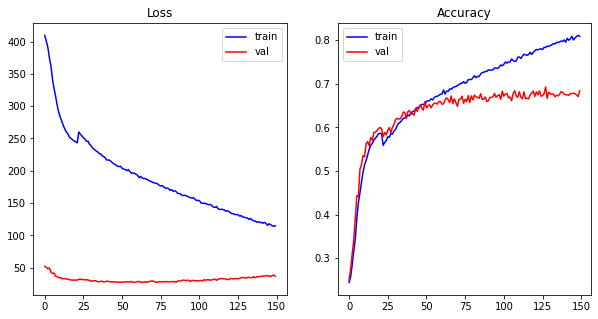

In [15]:
train_fer(150, './models', opt, scheduler, criterion, activation, model)

# VI. Testing

## Testing method

In [16]:
def test_scikit_ap(preds, labels):
  one_hot_labels = np.zeros((labels.shape[0], 7))
  one_hot_labels[np.arange(labels.shape[0]), labels.squeeze(1)] = 1
  ap = np.zeros(7, dtype=np.float32)
  for i in range(7):
    ap[i] = average_precision_score(one_hot_labels[:, i], preds[:, i])
  # print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_data(model, device, activation, data_loader, num_images):
    face_preds = np.zeros((num_images, 7))
    face_labels = np.zeros((num_images, 1), dtype=np.int32)
    face_preds_class = np.zeros((num_images, 1), dtype=np.int32)

    correct_pred = 0
    with torch.no_grad():
        model.to(device)
        model.eval()
        indx = 0
        print ('starting testing')
        for images_face, labels_face in iter(data_loader):
            images_face = images_face.to(device)
            labels_face = labels_face.to(device)
            log_preds_face = activation(model(images_face))
            preds_face = torch.exp(log_preds_face)
            topp, topk = preds_face.topk(1, dim=1)
            equals = topk == labels_face.view(*topk.shape)
            correct_pred += (equals == True).sum()
            face_preds_class[ indx : (indx + topk.shape[0]), :] = topk.to("cpu").data.numpy()
            face_preds[ indx : (indx + preds_face.shape[0]), :] = preds_face.to("cpu").data.numpy()
            face_labels[ indx : (indx + labels_face.shape[0]), :] = labels_face.to("cpu").unsqueeze(1).data.numpy()
            indx = indx + preds_face.shape[0]

    correct_pred = correct_pred.item()
    accuracy = correct_pred/num_images
    print ('completed testing')
    print ('accuracy = %.4f' %(accuracy))
    ap_mean = test_scikit_ap(face_preds, face_labels)
    print ('mean average precision = %.4f ' %(ap_mean))
    return face_preds_class, face_preds, face_labels, accuracy, ap_mean
  
print ('completed cell')

completed cell


## Evaluation results

In [17]:
model = torch.load(os.path.join('./models','model_fer_acc.pth'))

val_pred_class, val_pred_prob, val_label_class, val_acc, val_ap_mean = test_data(model, device, activation, val_loader, len(val_dataset))
test_pred_class, test_pred_prob, test_label_class, test_acc,test_ap_mean = test_data(model, device, activation, test_loader, len(test_dataset))

print ('Validation accuracy = %.4f , average_precision_mean = %.4f' %(val_acc, val_ap_mean))
print ('Testing accuracy = %.4f , average_precision_mean = %.4f' %(test_acc, test_ap_mean))

starting testing
completed testing
accuracy = 0.6924
mean average precision = 0.7137 
starting testing
completed testing
accuracy = 0.6977
mean average precision = 0.7309 
Validation accuracy = 0.6924 , average_precision_mean = 0.7137
Testing accuracy = 0.6977 , average_precision_mean = 0.7309


## Plots

In [18]:
!pip install scikit-plot

In [0]:
import scikitplot as skplt
test_pred_class_names = [indx2emotion[pred] for pred in test_pred_class.squeeze(1)]
test_label_class_names = [indx2emotion[label] for label in test_label_class.squeeze(1)]

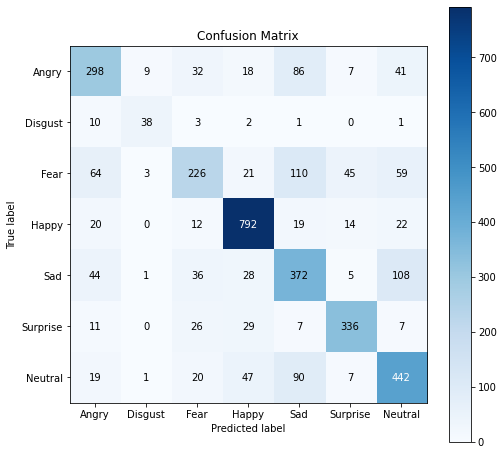

In [20]:
skplt.metrics.plot_confusion_matrix(test_label_class_names, test_pred_class_names, labels=list(indx2emotion.values()), figsize=(8,8))

In [21]:
print (classification_report(test_label_class_names, test_pred_class_names, target_names=list(indx2emotion.values())))

              precision    recall  f1-score   support

       Angry       0.64      0.61      0.62       491
     Disgust       0.73      0.69      0.71        55
        Fear       0.64      0.43      0.51       528
       Happy       0.85      0.90      0.87       879
         Sad       0.65      0.71      0.68       626
    Surprise       0.54      0.63      0.58       594
     Neutral       0.81      0.81      0.81       416

    accuracy                           0.70      3589
   macro avg       0.69      0.68      0.68      3589
weighted avg       0.70      0.70      0.69      3589



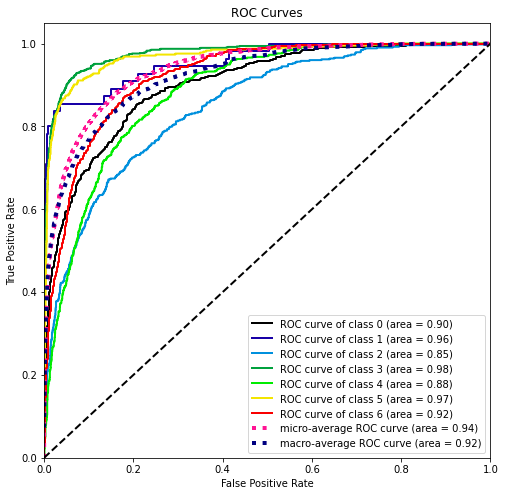

In [22]:
skplt.metrics.plot_roc(test_label_class, test_pred_prob, figsize=(8,8))

# VII. Model serving

In [23]:
model.to("cpu")
torch.save(model, '/content/drive/My Drive/Colab/MLEND/model_fer_acc.pth')

x = torch.rand(1,1,48,48)
with torch.no_grad():
  print (model(x))
  traced_cell = torch.jit.trace(model, (x))
torch.jit.save(traced_cell, '/content/drive/My Drive/Colab/MLEND/model_fer_acc_jit.pth')

model_jit = torch.load('/content/drive/My Drive/Colab/MLEND/model_fer_acc_jit.pth')
print (model_jit(x))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FER_basic_model3_new. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


tensor([[  7.6058, -23.2261,  -0.9805,   4.5940,  -4.5578, -12.6587,   2.7847]])
tensor([[  7.6058, -23.2261,  -0.9805,   4.5940,  -4.5578, -12.6587,   2.7847]],
       grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:590: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


## Model free-form vizualisation

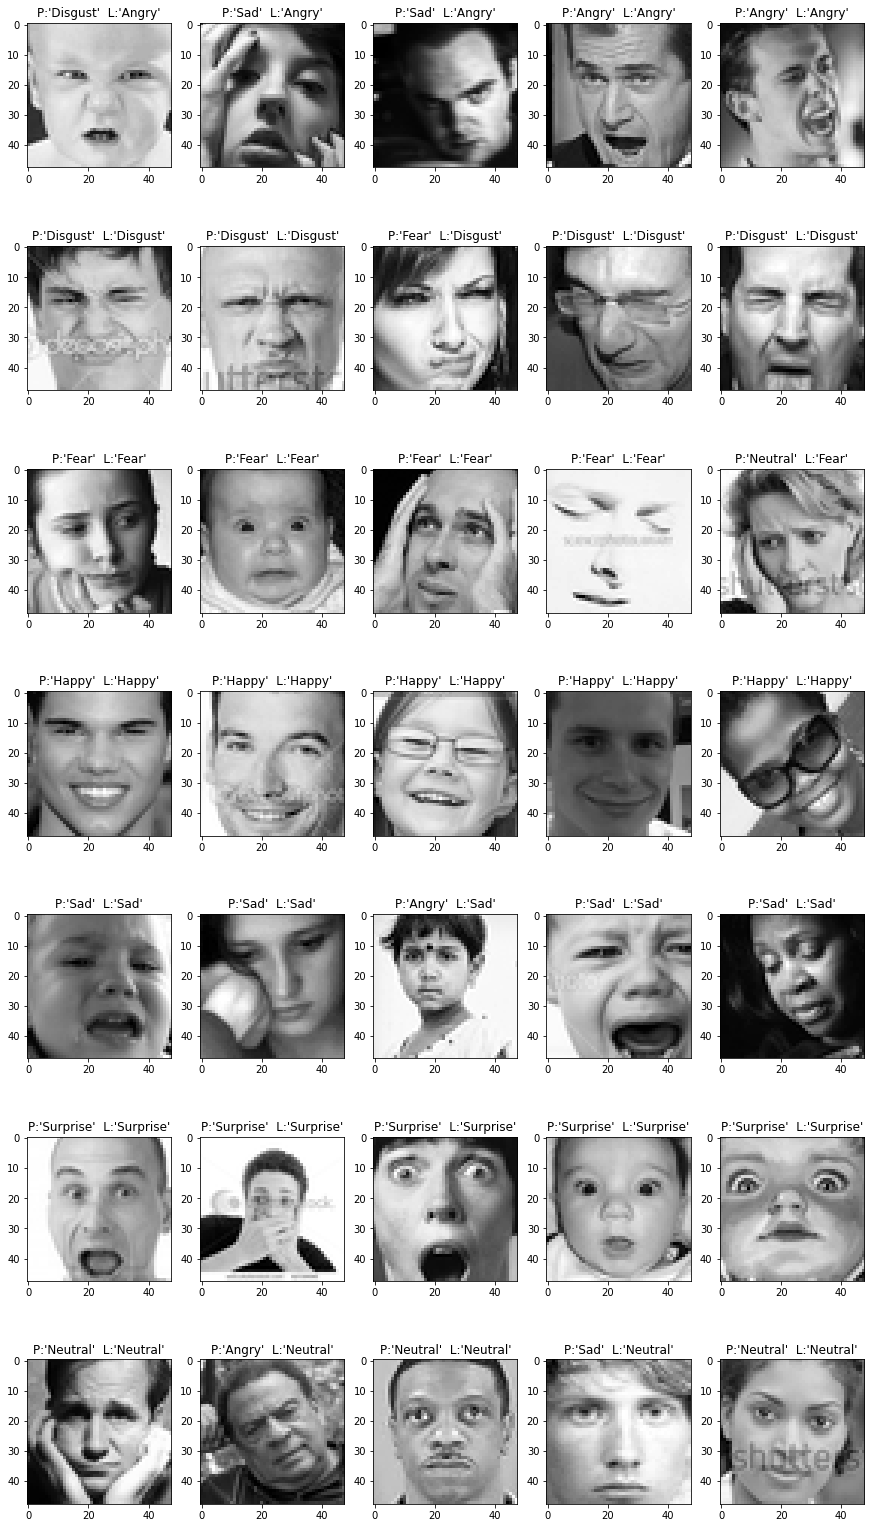

In [24]:
import random
plt.figure(figsize=[15,28])

def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(), transforms.Normalize([0.5077], [0.255])])
    return my_transforms(image).unsqueeze(0)


plots = 1
activation = nn.Softmax(dim=1)
for class_indx in range(7):
  class_imgs = random.sample(list(np.where(test_y == class_indx)[0]), 5)
  for image_idx in class_imgs:
    image = test_x[image_idx]
    with torch.no_grad():
      image = transform_image(image)
      pred_face = activation(model_jit(image))
      topp, topk = pred_face.topk(1, dim=1)
      topk = topk.item()
    pred = indx2emotion[int(topk)]

    plt.subplot(7, 5, plots)
    plt.imshow(image.reshape(48,48), cmap='gray')
    plt.title("P:%r  L:%r" %(pred, indx2emotion[class_indx]))
    plots += 1


plt.savefig('/content/drive/My Drive/Colab/MLEND/free_viz_final.png')
